In [1]:
!pip3 install matplotlib
!pip3 install numpy
!pip3 install seaborn

     |################################| 11.5 MB 820 kB/s            
     |################################| 14.8 MB 96 kB/s              
     |################################| 3.1 MB 19.8 MB/s            
     |################################| 1.1 MB 10.5 MB/s            
     |################################| 292 kB 1.7 MB/s            
     |################################| 9.5 MB 1.5 MB/s            
     |################################| 25.9 MB 194 kB/s            
     |################################| 503 kB 2.6 MB/s            


# Import Libaries, Packages and Declare Spark Session

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession\
        .builder.appName("Analyze Customer Prosensity")\
        .master("spark://hadoop-spark-master:7077")\
        .getOrCreate()

/usr/local/lib/python3.6/dist-packages/pyspark/context.py:238: FutureWarning: Python 3.6 support is deprecated in Spark 3.2.
  FutureWarning


# Data Preprocessing

In [4]:
# read data using Spark DataFrame
df = spark.read.csv("hdfs://hadoop-spark-master:9000/training.csv", header=True, inferSchema=True)

## EDA - Exploratory Data Analysis
Những thông tin cần biết từ dữ liệu:

1. Dữ liệu bao gồm bao nhiêu hàng, cột?
2. Phân bố dữ liệu của từng feature như thế nào?
3. Tên của các cột đã dể hiểu hay chưa?
4. Phân loại các biến continous và categorical
5. Dữ liệu có chứa NaN hay không?
6. Kiểm tra Outliners?

In [5]:
# xem schema
df.printSchema()

root
 |-- UserID: string (nullable = true)
 |-- basket_icon_click: integer (nullable = true)
 |-- basket_add_list: integer (nullable = true)
 |-- basket_add_detail: integer (nullable = true)
 |-- sort_by: integer (nullable = true)
 |-- image_picker: integer (nullable = true)
 |-- account_page_click: integer (nullable = true)
 |-- promo_banner_click: integer (nullable = true)
 |-- detail_wishlist_add: integer (nullable = true)
 |-- list_size_dropdown: integer (nullable = true)
 |-- closed_minibasket_click: integer (nullable = true)
 |-- checked_delivery_detail: integer (nullable = true)
 |-- checked_returns_detail: integer (nullable = true)
 |-- sign_in: integer (nullable = true)
 |-- saw_checkout: integer (nullable = true)
 |-- saw_sizecharts: integer (nullable = true)
 |-- saw_delivery: integer (nullable = true)
 |-- saw_account_upgrade: integer (nullable = true)
 |-- saw_homepage: integer (nullable = true)
 |-- device_mobile: integer (nullable = true)
 |-- device_computer: integer (n

In [7]:
# xem dữ liệu
df.toPandas().head(5)

,UserID,basket_icon_click,basket_add_list,basket_add_detail,sort_by,image_picker,account_page_click,promo_banner_click,detail_wishlist_add,list_size_dropdown,...,saw_sizecharts,saw_delivery,saw_account_upgrade,saw_homepage,device_mobile,device_computer,device_tablet,returning_user,loc_uk,ordered
0,a720-6b732349-a720-4862-bd21-644732,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,a0c0-6b73247c-a0c0-4bd9-8baa-797356,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,86a8-6b735c67-86a8-407b-ba24-333055,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
3,6a3d-6b736346-6a3d-4085-934b-396834,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
4,b74a-6b737717-b74a-45c3-8c6a-421140,0,1,0,1,0,0,0,0,1,...,0,0,0,1,0,0,1,0,1,1


In [10]:
# check số dòng
df.count()

455401

In [12]:
# check các đại lượng của các columns dạng numeric
numeric_cols = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_cols).toPandas().describe()

,basket_icon_click,basket_add_list,basket_add_detail,sort_by,image_picker,account_page_click,promo_banner_click,detail_wishlist_add,list_size_dropdown,closed_minibasket_click,...,saw_sizecharts,saw_delivery,saw_account_upgrade,saw_homepage,device_mobile,device_computer,device_tablet,returning_user,loc_uk,ordered
count,455401.000000,455401.000000,455401.000000,455401.000000,455401.000000,455401.000000,455401.000000,455401.000000,455401.000000,455401.000000,...,455401.000000,455401.000000,455401.000000,455401.000000,455401.000000,455401.000000,455401.000000,455401.000000,455401.000000,455401.000000
mean,0.099150,0.074521,0.112916,0.036849,0.026735,0.003570,0.016208,0.003511,0.230362,0.017277,...,0.000389,0.005542,0.001096,0.290024,0.680706,0.194220,0.128364,0.534915,0.933224,0.041926
std,0.298864,0.262617,0.316490,0.188391,0.161307,0.059647,0.126274,0.059151,0.421065,0.130302,...,0.019711,0.074241,0.033084,0.453773,0.466204,0.395599,0.334495,0.498780,0.249634,0.200420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


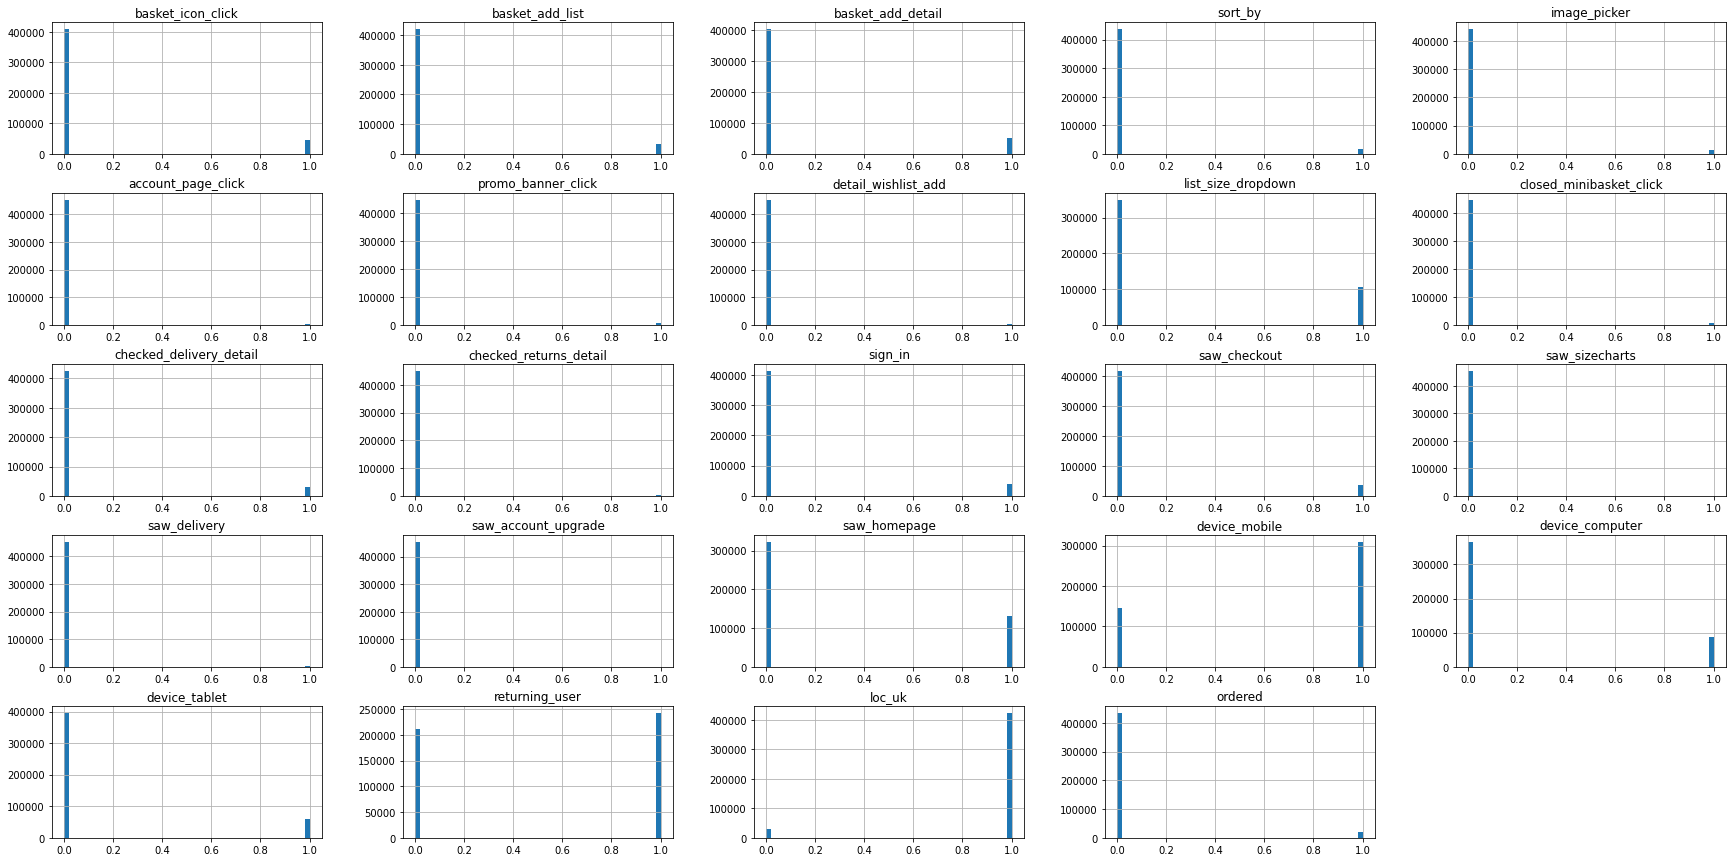

In [13]:
# visualize phân bố dữ liệu
df.select(numeric_cols).toPandas().hist(bins=50,figsize=(30, 15))
plt.show()

### Kiểm tra giá trị NaN của các features

In [15]:
# check dữ liệu NaN
from pyspark.sql.functions import col,isnan,when,count

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in numeric_cols]).show(vertical=True)

-RECORD 0----------------------
 basket_icon_click       | 0   
 basket_add_list         | 0   
 basket_add_detail       | 0   
 sort_by                 | 0   
 image_picker            | 0   
 account_page_click      | 0   
 promo_banner_click      | 0   
 detail_wishlist_add     | 0   
 list_size_dropdown      | 0   
 closed_minibasket_click | 0   
 checked_delivery_detail | 0   
 checked_returns_detail  | 0   
 sign_in                 | 0   
 saw_checkout            | 0   
 saw_sizecharts          | 0   
 saw_delivery            | 0   
 saw_account_upgrade     | 0   
 saw_homepage            | 0   
 device_mobile           | 0   
 device_computer         | 0   
 device_tablet           | 0   
 returning_user          | 0   
 loc_uk                  | 0   
 ordered                 | 0   



**Kết luận**

**Dữ liệu bao gồm:** 455401 recors, 24 columns

**Tên của các features:** Dễ hiểu, không cần thực hiện thay đổi

**Dữ liệu của các features:** Không cần thực hiện thay đổi vì mọi features đều ở dạng binary categorical

**Ta phân loại được:**
+ **Categorical features:** basket_icon_click, basket_add_list, basket_add_detail, sort_by, image_picker, account_page_click, omo_banner_click, detail_wishlist_add, list_size_dropdown, closed_minibasket_click, checked_delivery_detail, checked_returns_detail, sign_in, saw_checkout, saw_sizecharts, saw_delivery, saw_account_upgrade, saw_homepage, device_mobile, device_computer, device_tablet, returning_user, loc_uk, ordered
+ **Label:** Ordered

**NaN data:** Các features không chứa NaN data

**Outliers:** Các features không chứa outliers vì đều ở dạng binary categorical

# Feature Engineering

# Stop Spark Session

In [16]:
spark.getActiveSession()

In [17]:
spark.stop()

In [18]:
spark.getActiveSession()